In [1]:
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
from utils.utils import df_stats

#### Set up Data to be compatible with model

##### Regression Model Data Wrangling and Set Up
comment out if not using regression

In [2]:
# Parameters
CELL_TYPE = "PBMC"
CONTROL_NAME = "DMSO_0.100_DMSO_0.025"
# TREATMENT_NAME = "LPS_100.000_DMSO_0.025"
TREATMENT_NAME = "DMSO_0.100_DMSO_0.025"
MODEL_NAME = "DMSO_0.025_vs_LPS_100"
SHUFFLE = False

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/regression_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.CONTROL_NAME = CONTROL_NAME
mlp_params.TREATMENT_NAME = TREATMENT_NAME
mlp_params.SHUFFLE = SHUFFLE

In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

# file_path = pathlib.Path(
#     f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
# ).resolve(strict=True)

file_path = pathlib.Path(
    "../../../data/PBMC_subset_sc_norm_DMSO_0.100_DMSO_0.025_LPS_100.000_DMSO_0.025.parquet"
)

# set path for nomic data
nomic_df_path = pathlib.Path(
    f"../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_{mlp_params.CELL_TYPE}_cleanup4correlation.csv"
).resolve(strict=True)

df = pq.read_table(file_path).to_pandas()
nomic_df = pd.read_csv(nomic_df_path)

In [5]:
# change the nomic df to standard scaler
# select the columns that contain "NSU"
nomic_df_scaled = nomic_df.filter(regex="NSU")
# standardize the nomic data
# scaler = preprocessing.StandardScaler()
# nomic_df_scaled = pd.DataFrame(scaler.fit_transform(nomic_df_scaled), columns=nomic_df_scaled.columns)
# add the nomic data metadata back
nomic_df_scaled[
    [
        "Metadata_position_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ]
] = nomic_df[
    [
        "Metadata_position_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ]
]
nomic_df = nomic_df_scaled.copy()
del nomic_df_scaled

/tmp/ipykernel_2048220/966290204.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nomic_df_scaled[[
/tmp/ipykernel_2048220/966290204.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nomic_df_scaled[[


In [6]:
print(df.shape)
df = pd.merge(
    df,
    nomic_df,
    left_on=[
        "Metadata_Well",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
    right_on=[
        "Metadata_position_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    ],
).drop(["Metadata_position_x"], axis=1)
print(nomic_df.shape)
print(df.shape)

(374565, 1270)
(154, 190)
(374565, 1457)


In [7]:
df_merge_non_aggregated = df.copy()

In [8]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [9]:
df_values[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
] = df_descriptive[["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]]
df = (
    df_values.groupby(["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"])
    .median()
    .reset_index()
)

In [10]:
# filter the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column to only include the treatment and control via loc
df = df.loc[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(
        [mlp_params.TREATMENT_NAME, mlp_params.CONTROL_NAME]
    )
]


print("Selected Catagories are:")
print(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
df_stats(df)

if mlp_params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=mlp_params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

Selected Catagories are:
['DMSO_0.100_DMSO_0.025']
The dimensions of the data are: (8, 1434)
Number of total missing values across all columns: 0
Data Subset Is Off


In [11]:
np.random.seed(seed=0)
wells_to_hold = (
    df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
    .agg(np.random.choice)["Metadata_Well"]
    .to_list()
)
df_holdout = df[df["Metadata_Well"].isin(wells_to_hold)]
df = df[~df["Metadata_Well"].isin(wells_to_hold)]


print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
print(
    "Wells to use for training, validation, and testing", df["Metadata_Well"].unique()
)

Wells held out for testing: ['I06']
Wells to use for training, validation, and testing ['B06' 'B07' 'C06' 'C07' 'I07' 'J06' 'J07']


In [12]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [13]:
# get all columns that contain NSU in the name
df_values_Y = df_values[df_values.columns[df_values.columns.str.contains("NSU")]]
df_values_X = df_values.drop(columns=df_values_Y.columns)
# drop all columns except for IL1B and TNFa
col = ["IL-1 beta [NSU]"]
df_values_Y = df_values_Y[col]
df_values_Y["Metadata_Well"] = df_descriptive["Metadata_Well"]
print(df_values.shape)
print(df_values_X.shape)
print(df_values_Y.shape)

(7, 1432)
(7, 1245)
(7, 2)


#### Split Data - All Models can proceed through this point

In [14]:
X_train, X_test, X_val, Y_train_well, Y_test_well, Y_val_well = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=0,
    params=mlp_params,
)

In [15]:
Y_train = Y_train_well.drop(columns=["Metadata_Well"])
Y_test = Y_test_well.drop(columns=["Metadata_Well"])
Y_val = Y_val_well.drop(columns=["Metadata_Well"])

In [16]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [17]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = Y_train.shape[1]
else:
    mlp_params.OUT_FEATURES = len(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
    )

print("Number of out features: ", mlp_params.OUT_FEATURES)

Number of in features:  1245
Number of out features:  1


In [18]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

### Train the Model

In [19]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    mlp_params,
    mlp_params.MODEL_NAME,
)
# get training_metrics
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

RMSprop
Epoch 0: Validation loss decreased (inf --> 0.000433).  Saving model ...
Epoch 1: Validation loss decreased (0.000433 --> 0.000413).  Saving model ...
Epoch 2: Validation loss decreased (0.000413 --> 0.000413).  Saving model ...
Epoch 3: Validation loss did not decrease
Epoch 4: Validation loss did not decrease
Epoch 5: Validation loss did not decrease
Epoch 6: Validation loss did not decrease
Epoch 7: Validation loss did not decrease
Epoch 8: Validation loss did not decrease
Epoch 9: Validation loss did not decrease
Epoch 10: Validation loss did not decrease
Epoch 11: Validation loss did not decrease
Epoch 12: Validation loss did not decrease
Epoch 13: Validation loss did not decrease
Epoch 14: Validation loss did not decrease
Epoch 15: Validation loss did not decrease
Epoch 16: Validation loss did not decrease
Epoch 17: Validation loss did not decrease
Epoch 18: Validation loss did not decrease
Early stopped at epoch : 18


/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [20]:
model

Sequential(
  (0): Linear(in_features=1245, out_features=3, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.40985422083877227, inplace=False)
  (3): Linear(in_features=3, out_features=2, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1943899612624775, inplace=False)
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [21]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=params.MODEL_NAME,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1001: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1002: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


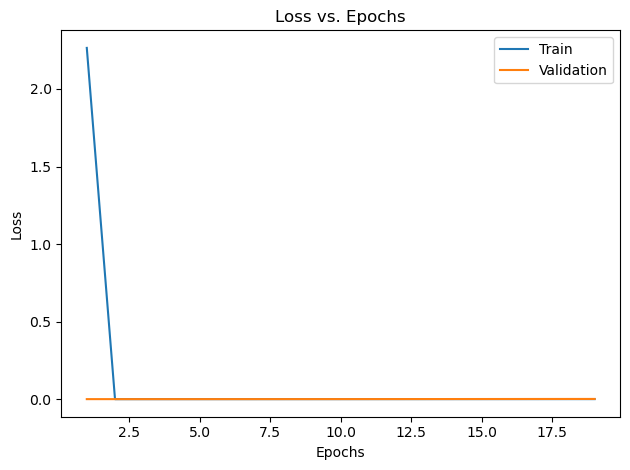

In [22]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=params.MODEL_NAME,
)

### Test the trained model with train data

In [23]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, train_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, train_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_train):
    print("yes")
    if mlp_params.MODEL_TYPE != "Regression":
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        y_pred_list = un_nest(y_pred_list)
else:
    pass

DMSO_0.025_vs_LPS_100


In [24]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(y_pred_list, columns=Y_train.columns, index=Y_train.index)
prediction_df["Metadata_Well"] = Y_train_well["Metadata_Well"]
prediction_df["Metadata_Well"].unique()
prediction_df.head()

,IL-1 beta [NSU],Metadata_Well
0,0.018317,C07
1,0.018317,B07
2,0.018317,B06
3,0.018317,C06
4,0.018317,J06


In [25]:
y_pred_list

[0.01831691339612007,
 0.01831691339612007,
 0.01831691339612007,
 0.01831691339612007,
 0.01831691339612007]

In [26]:
Y_train

,IL-1 beta [NSU]
0,0.028148
1,0.040659
2,0.018241
3,0.030450
4,0.021020


In [27]:
testing_values = pd.DataFrame(columns=["Actual", "Average Predicted", "cytokine"])

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

# get the list of columns in the test data
test_data_columns = Y_train.columns.to_list()
# loop through the columns
for col in Y_train:
    # get the column from test data
    test_col = Y_train[col]
    # get the column from prediction data
    pred_col = prediction_df[col]
    # list of treatment names
    treatment_col = prediction_df["Metadata_Well"]
    # get the mse and r2 for the columns
    # mse = mean_squared_error(test_col, pred_col)
    # r_square = r2_score(test_col, pred_col)
    # a, b = np.polyfit(test_col, pred_col, 1)
    index_dict = {}
    for i in test_col.unique():
        index_list = []
        for j in enumerate(test_col):
            if i == j[1]:
                index_list.append(j[0])
        index_dict[i] = index_list
    new_value_dict = {}
    for i in index_dict:
        new_value_dict[i] = [
            pred_col[index_dict[i]].median(),
            treatment_col[index_dict[i]].unique().tolist()[0],
        ]

    df = (
        pd.DataFrame.from_dict(new_value_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
    )
    df["cytokine"] = col
    df["model_type"] = "train"
    df["shuffled_data"] = mlp_params.SHUFFLE

    testing_values = pd.concat([testing_values, df], axis=0)
    # plt.scatter(df['Actual'], df['Average Predicted'])
    # # plt.plot([min(test_col), max(test_col)], [min(test_col), max(test_col)], color='red', linestyle='--')
    # plt.plot(
    #     test_col,
    #     a * test_col + b,
    #     color="red",
    #     label="R2={0:0.2f}".format(r_square),
    # )
    # plt.title(
    #     f"Regression Nerual Network Prediction vs. True \n {col}", fontsize=25
    # )
    # plt.ylabel("Predicted", fontsize=18)
    # plt.xlabel("Target", fontsize=18)
    # # make data continuous
    # plt.show()
    # plt.close()

In [29]:
# get the unique rows in a dataframe
key_df = df_descriptive[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
].drop_duplicates()
key_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,B06,DMSO_0.100_DMSO_0.025
1,B07,DMSO_0.100_DMSO_0.025
2,C06,DMSO_0.100_DMSO_0.025
3,C07,DMSO_0.100_DMSO_0.025
5,I07,DMSO_0.100_DMSO_0.025
8,J06,DMSO_0.100_DMSO_0.025
9,J07,DMSO_0.100_DMSO_0.025


In [30]:
# add treatment column based on well
testing_values = pd.merge(testing_values, key_df, on="Metadata_Well", how="left")

In [31]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025


### Test the trained model with validation data

In [32]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, valid_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, valid_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_val):
    print("yes")
    if mlp_params.MODEL_TYPE != "Regression":
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        y_pred_list = un_nest(y_pred_list)
else:
    pass

DMSO_0.025_vs_LPS_100


In [33]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(y_pred_list, columns=Y_val.columns, index=Y_val.index)
prediction_df["Metadata_Well"] = Y_val_well["Metadata_Well"]
prediction_df["Metadata_Well"].unique()
prediction_df.head()

,IL-1 beta [NSU],Metadata_Well
0,0.018317,J07


In [34]:
from sklearn.metrics import mean_squared_error, r2_score

# get the list of columns in the test data
test_data_columns = Y_val.columns.to_list()
# loop through the columns
for col in Y_val:
    # get the column from test data
    test_col = Y_val[col]
    # get the column from prediction data
    pred_col = prediction_df[col]
    # list of treatment names
    treatment_col = prediction_df["Metadata_Well"]
    # get the mse and r2 for the columns
    # mse = mean_squared_error(test_col, pred_col)
    # r_square = r2_score(test_col, pred_col)
    # a, b = np.polyfit(test_col, pred_col, 1)
    index_dict = {}
    for i in test_col.unique():
        index_list = []
        for j in enumerate(test_col):
            if i == j[1]:
                index_list.append(j[0])
        index_dict[i] = index_list
    new_value_dict = {}
    for i in index_dict:
        new_value_dict[i] = [
            pred_col[index_dict[i]].median(),
            treatment_col[index_dict[i]].unique().tolist()[0],
        ]

    df = (
        pd.DataFrame.from_dict(new_value_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
    )
    df["cytokine"] = col
    df["model_type"] = "validation"
    df["shuffled_data"] = mlp_params.SHUFFLE

    testing_values = pd.concat([testing_values, df], axis=0)

In [35]:
# get the unique rows in a dataframe
key_df = df_descriptive[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
].drop_duplicates()
key_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,B06,DMSO_0.100_DMSO_0.025
1,B07,DMSO_0.100_DMSO_0.025
2,C06,DMSO_0.100_DMSO_0.025
3,C07,DMSO_0.100_DMSO_0.025
5,I07,DMSO_0.100_DMSO_0.025
8,J06,DMSO_0.100_DMSO_0.025
9,J07,DMSO_0.100_DMSO_0.025


In [36]:
# add treatment column based on well
testing_values = pd.merge(testing_values, key_df, on="Metadata_Well", how="left")

In [37]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,NaN,DMSO_0.100_DMSO_0.025


In [38]:
testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = testing_values[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y"
]
testing_values.drop(
    columns=[
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y",
    ],
    inplace=True,
)
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,DMSO_0.100_DMSO_0.025


### Testing model

In [39]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    print("yes")
    if not params.MODEL_TYPE == "Regression":

        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        y_pred_list = un_nest(y_pred_list)
else:
    pass

DMSO_0.025_vs_LPS_100


In [40]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(y_pred_list, columns=Y_test.columns, index=Y_test.index)
prediction_df["Metadata_Well"] = Y_test_well["Metadata_Well"]
prediction_df["Metadata_Well"].unique()
prediction_df

,IL-1 beta [NSU],Metadata_Well
0,0.018317,I07


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

# get the list of columns in the test data
test_data_columns = Y_test.columns.to_list()
# loop through the columns
for col in Y_test:
    # get the column from test data
    test_col = Y_test[col]
    # get the column from prediction data
    pred_col = prediction_df[col]
    # list of treatment names
    treatment_col = prediction_df["Metadata_Well"]
    # get the mse and r2 for the columns
    # mse = mean_squared_error(test_col, pred_col)
    # r_square = r2_score(test_col, pred_col)
    # a, b = np.polyfit(test_col, pred_col, 1)
    treatment_col = prediction_df["Metadata_Well"]
    index_dict = {}
    for i in test_col.unique():
        index_list = []
        for j in enumerate(test_col):
            if i == j[1]:
                index_list.append(j[0])
        index_dict[i] = index_list
    new_value_dict = {}
    for i in index_dict:
        new_value_dict[i] = [
            pred_col[index_dict[i]].median(),
            treatment_col[index_dict[i]].unique().tolist()[0],
        ]

    df = (
        pd.DataFrame.from_dict(new_value_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
    )
    df["cytokine"] = col
    df["model_type"] = "test"
    df["shuffled_data"] = mlp_params.SHUFFLE

    testing_values = pd.concat([testing_values, df], axis=0)
    # plt.scatter(df['Actual'], df['Average Predicted'])
    # # plt.plot([min(test_col), max(test_col)], [min(test_col), max(test_col)], color='red', linestyle='--')
    # plt.plot(
    #     test_col,
    #     a * test_col + b,
    #     color="red",
    #     label="R2={0:0.2f}".format(r_square),
    # )
    # plt.title(
    #     f"Regression Nerual Network Prediction vs. True \n {col}", fontsize=25
    # )
    # plt.ylabel("Predicted", fontsize=18)
    # plt.xlabel("Target", fontsize=18)
    # # make data continuous
    # plt.show()
    # plt.close()

In [42]:
# get the unique rows in a dataframe
key_df = df_descriptive[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
].drop_duplicates()
key_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,B06,DMSO_0.100_DMSO_0.025
1,B07,DMSO_0.100_DMSO_0.025
2,C06,DMSO_0.100_DMSO_0.025
3,C07,DMSO_0.100_DMSO_0.025
5,I07,DMSO_0.100_DMSO_0.025
8,J06,DMSO_0.100_DMSO_0.025
9,J07,DMSO_0.100_DMSO_0.025


In [43]:
# add treatment column based on well
testing_values = pd.merge(testing_values, key_df, on="Metadata_Well", how="left")

In [44]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,DMSO_0.100_DMSO_0.025,DMSO_0.100_DMSO_0.025
6,0.026229,0.018317,IL-1 beta [NSU],I07,test,False,NaN,DMSO_0.100_DMSO_0.025


In [45]:
testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = testing_values[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y"
]
testing_values.drop(
    columns=[
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y",
    ],
    inplace=True,
)
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,DMSO_0.100_DMSO_0.025
6,0.026229,0.018317,IL-1 beta [NSU],I07,test,False,DMSO_0.100_DMSO_0.025


# Hold out

In [46]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df_holdout.columns[df_holdout.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df_holdout[df_metadata]
df_values = df_holdout.drop(columns=df_metadata)

In [47]:
# get all columns that contain NSU in the name
df_values_Y = df_values[df_values.columns[df_values.columns.str.contains("NSU")]]
df_values_X = df_values.drop(columns=df_values_Y.columns)
# drop all columns except for IL1B and TNFa
col = ["IL-1 beta [NSU]"]
df_values_Y = df_values_Y[col]
df_values_Y["Metadata_Well"] = df_descriptive["Metadata_Well"]
print(df_values.shape)
print(df_values_X.shape)
print(df_values_Y.shape)

(1, 1432)
(1, 1245)
(1, 2)


In [48]:
df_values_Y_well = df_values_Y
df_values_Y = df_values_Y.drop(columns=["Metadata_Well"])

In [49]:
test_data = Dataset_formatter(
    torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
)

# convert data class into a dataloader to be compatible with pytorch
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [50]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model, test_loader, params, model_name=params.MODEL_NAME
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(df_values_Y):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

DMSO_0.025_vs_LPS_100


In [51]:
y_pred_list

[0.01831691339612007]

In [53]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(
    y_pred_list, columns=df_values_Y.columns, index=df_values_Y.index
)
prediction_df.head(2)

,IL-1 beta [NSU]
4,0.018317


In [54]:
print(df_values_Y.shape, prediction_df.shape)
df_values_Y.head(2)
prediction_df.head(2)

(1, 1) (1, 1)


,IL-1 beta [NSU]
4,0.018317


In [55]:
# make the prediction list into a dataframe using column names from the test data
prediction_df = pd.DataFrame(
    y_pred_list, columns=df_values_Y.columns, index=df_values_Y.index
)
prediction_df["Metadata_Well"] = df_values_Y_well["Metadata_Well"]
prediction_df["Metadata_Well"].unique()

array(['I06'], dtype=object)

In [56]:
df_values_Y.reset_index(drop=True, inplace=True)
prediction_df.reset_index(drop=True, inplace=True)

In [57]:
from sklearn.metrics import mean_squared_error, r2_score

# get the list of columns in the test data
test_data_columns = df_values_Y.columns.to_list()
# loop through the columns
for col in test_data_columns:
    # get the column from test data
    test_col = df_values_Y[col]
    # get the column from prediction data
    pred_col = prediction_df[col]
    # list of treatment names
    treatment_col = prediction_df["Metadata_Well"]
    # get the mse and r2 for the columns
    mse = mean_squared_error(test_col, pred_col)
    r_square = r2_score(test_col, pred_col)
    a, b = np.polyfit(test_col, pred_col, 1)
    index_dict = {}
    for i in test_col.unique():
        index_list = []
        for j in enumerate(test_col):
            if i == j[1]:
                index_list.append(j[0])
        index_dict[i] = index_list
    new_value_dict = {}
    for i in index_dict:
        new_value_dict[i] = [
            pred_col[index_dict[i]].median(),
            treatment_col[index_dict[i]].unique().tolist()[0],
        ]

    df = (
        pd.DataFrame.from_dict(new_value_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "Actual", 0: "Average Predicted", 1: "Metadata_Well"})
    )
    df["cytokine"] = col
    df["model_type"] = "holdout"
    df["shuffled_data"] = mlp_params.SHUFFLE

    testing_values = pd.concat([testing_values, df], axis=0)

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [58]:
# get the unique rows in a dataframe
key_df = df_descriptive[
    ["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
].drop_duplicates()
key_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
4,I06,DMSO_0.100_DMSO_0.025


In [59]:
# add treatment column based on well
testing_values = pd.merge(testing_values, key_df, on="Metadata_Well", how="left")

In [60]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x,oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025,NaN
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025,NaN
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025,NaN
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025,NaN
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025,NaN
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,DMSO_0.100_DMSO_0.025,NaN
6,0.026229,0.018317,IL-1 beta [NSU],I07,test,False,DMSO_0.100_DMSO_0.025,NaN
7,0.025924,0.018317,IL-1 beta [NSU],I06,holdout,False,NaN,DMSO_0.100_DMSO_0.025


In [61]:
# merge the x and y columns together and drop the nan values
testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = testing_values[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x"
].fillna(testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y"])
testing_values.drop(
    columns=[
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_x",
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose_y",
    ],
    inplace=True,
)
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,DMSO_0.100_DMSO_0.025
6,0.026229,0.018317,IL-1 beta [NSU],I07,test,False,DMSO_0.100_DMSO_0.025
7,0.025924,0.018317,IL-1 beta [NSU],I06,holdout,False,DMSO_0.100_DMSO_0.025


In [62]:
model

Sequential(
  (0): Linear(in_features=1245, out_features=3, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.40985422083877227, inplace=False)
  (3): Linear(in_features=3, out_features=2, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1943899612624775, inplace=False)
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [63]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/regression_results_training.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, testing_values], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    testing_values.to_csv(metrics_file, index=False)

#

In [64]:
testing_values

,Actual,Average Predicted,cytokine,Metadata_Well,model_type,shuffled_data,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,0.028148,0.018317,IL-1 beta [NSU],C07,train,False,DMSO_0.100_DMSO_0.025
1,0.040659,0.018317,IL-1 beta [NSU],B07,train,False,DMSO_0.100_DMSO_0.025
2,0.018241,0.018317,IL-1 beta [NSU],B06,train,False,DMSO_0.100_DMSO_0.025
3,0.030450,0.018317,IL-1 beta [NSU],C06,train,False,DMSO_0.100_DMSO_0.025
4,0.021020,0.018317,IL-1 beta [NSU],J06,train,False,DMSO_0.100_DMSO_0.025
5,0.038622,0.018317,IL-1 beta [NSU],J07,validation,False,DMSO_0.100_DMSO_0.025
6,0.026229,0.018317,IL-1 beta [NSU],I07,test,False,DMSO_0.100_DMSO_0.025
7,0.025924,0.018317,IL-1 beta [NSU],I06,holdout,False,DMSO_0.100_DMSO_0.025


In [65]:
testing_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['DMSO_0.100_DMSO_0.025'], dtype=object)